In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from random import randint
import scipy.stats as st
from scipy import ndimage
import bisect
%matplotlib inline

In [3]:
def gabor_fn(sigma, theta, Lambda, psi, gamma):
    sigma_x = sigma
    sigma_y = float(sigma) / gamma

    # Bounding box
    nstds = 3 # Number of standard deviation sigma
    xmax = max(abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta)))
    xmax = np.ceil(max(1, xmax))
    ymax = max(abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta)))
    ymax = np.ceil(max(1, ymax))
    xmin = -xmax
    ymin = -ymax
    (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))

    # Rotation 
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    gb = np.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * np.cos(2 * np.pi / Lambda * x_theta + psi)
    return gb

In [4]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel array."""

    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

def Crop(Image):
    L=len(Image)
    l=len(Image[0])
    SizeL=np.int(np.log2(L))
    Sizel=np.int(np.log2(l))
    if 2**SizeL==L and 2**Sizel == l:
        return Image
    else:
        Side=min([SizeL,Sizel])
        Cropped=np.zeros([2**Side,2**Side])
        Cropped[:]=Image[int(L/2)-2**(Side-1):int(L/2)+2**(Side-1),int(l/2)-2**(Side-1):int(l/2)+2**(Side-1)]
        return Cropped

def Reduce(data):
    b=SubSample(LowPassFilter(data))
    return b

def Expand(data):
    l=LowPassFilter(UpSample(data))
    return l

def SubSample(data):
    Size=np.array(data.shape,dtype=np.int)/2
    return data[0::2,0::2]

def UpSample(data):
    Size=np.array(data.shape,dtype=np.int)*2
    UpSampled=np.zeros(Size)
    UpSampled[0::2,0::2]=data[:,:]
    return UpSampled

def LowPassFilter(data):
    Sfilter=2
    Filter2D=np.array([[1,4,6,4,1],[4,16,24,16,4],[6,24,36,24,6],[4,16,24,16,4],[1,4,6,4,1]])*1/256.0
#     Filter2D=np.array([[1,-1,1],[0,0,0],[1,-1,1]])/2
    Result=ndimage.convolve(data, Filter2D, mode='wrap')
    return(Result)
    

class PyramidNode:
    def __init__(self,data):
        self.data=data
    def updateData(self,newdata):
        self.data=newdata

class Pyramid:
    def __init__(self,img):
        self.img=img
        self.depth=0
        self.Llist=[PyramidNode(Reduce(img))]
        self.Blist=[PyramidNode(img-Expand(self.Llist[0].data))]
        self.size=np.array(self.Llist[0].data.shape)

    def makePyramid(self,loop):
        for i in range(loop):
            self.Llist.append(PyramidNode(Reduce((self.Llist[self.depth]).data)))
            self.Blist.append(PyramidNode(self.Llist[self.depth].data-Expand(self.Llist[self.depth+1].data)))
            self.depth=self.depth+1

    def getL(self,level):
        if level<=self.depth:
            return(self.Llist[level].data)
        else:
            return 0

    def getB(self,level):
        if level<=self.depth:
            return(self.Blist[level].data)
        else:
            return 0
    
    def updateL(self,level,data):
        self.Llist[level].updateData(data)
        
    def updateB(self,level,data):
        self.Blist[level].updateData(data)
    
    def CollapsePyramid(self):
        for i in range(self.depth,0,-1):
            self.updateL(i-1,Expand(self.getL(i))+self.getB(i))
        return Expand(self.getL(0))+self.getB(0)
        
def MatchHistogram(Noise,Sample):
    M=len(Noise)
    N=len(Noise[0])
    BaseImRavel=np.copy(Sample).ravel()
    NoiseImRavel=np.copy(Noise).ravel()
    BaseSorted=np.argsort(BaseImRavel)
    NoiseSorted=np.argsort(NoiseImRavel)
    for i in range(M*N):
        NoiseImRavel[NoiseSorted[i]]=BaseImRavel[BaseSorted[i]]
    return np.reshape(NoiseImRavel,[M,N])

def MatchTexture(texture,depth=2,loop=5):
    Cropped=Crop(texture)
    noise=np.random.randint(255, size=(len(Cropped), len(Cropped)))
    noise=MatchHistogram(noise,Cropped)
    PyrText=Pyramid(Cropped)
    PyrText.makePyramid(depth)
    for i in range(loop):
        PyrNoise=Pyramid(noise)
        PyrNoise.makePyramid(depth)
        for j in range(depth):
            PyrNoise.updateB(j,MatchHistogram(PyrNoise.getB(j),PyrText.getB(j)))
#             plt.imshow(PyrNoise.getB(j))
#             plt.show()
        noise=np.array(np.round(PyrNoise.CollapsePyramid()),dtype=np.int)
    noise=MatchHistogram(noise,Cropped)
    return noise

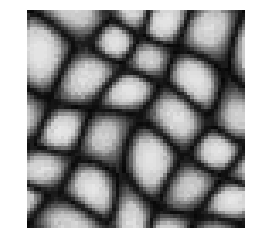

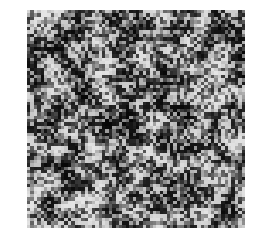

In [6]:
img=rgb2gray(np.array(mpimg.imread('../../161.gif'))[:,:,:3])
plt.imshow(img,cmap='gray',vmin=0,vmax=255)
plt.axis('off')
plt.show()
noise=MatchTexture(img,5,4)
plt.imshow(noise,cmap='gray',vmin=0,vmax=255)
plt.axis('off')
plt.show()